## 4. Multiscale Modelling (Hierarchical Filter + Vector Simplification)

In [40]:
from map2loop import m2l_subsampling 
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

In [41]:
%run -i "../test_data_vector/m2l_subsampling_config.py"

## Hierarchical Filtering

In [42]:
wa = gpd.read_file(western_australia)

In [43]:
for col in wa.columns: 
    print(col) 

CODE
UNITNAME
DESCRIPTN
SYMBOL
SORT
LITHSTRTNO
CODE_1
UNITNAME_1
GSWASTATUS
RANK
DESCRIPT_1
PARENTCODE
PARENTNAME
ROCKTYPE1
LITHNAME1
QUALIFIER1
QUALIFIER2
MIXEDROCK
ROCKTYPE2
LITHNAME2
MIXEDQUAL1
MIXEDQUAL2
WASTRAUNIT
SUPERSUITE
SUITE
SUPERGROUP
GROUP_
SUBGROUP
FORMATION
MEMBER
BED
STATE
WATECTUNIT
SSUITE_TEC
SUITE_TEC
CRATON
SUPERTERRA
CRATON_TER
DOMAIN_
GREENSTONE
SUPERBASIN
BASIN
SUBBASIN
SUBBASIN_E
OROGEN
PROVINCE
PROV_TZONE
TECT_SUBDI
OROG_FOR
OROG_FORSU
IN_OUTLIER
EVENTS
AGEFROM
AGETO
MAX_AGE_MA
MAXUNCERTY
MIN_AGE_MA
MINUNCERTY
MAX_AGE_DA
MIN_AGE_DA
geometry


In [44]:
#fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
#ax1=wa.plot(column='PROVINCE',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax1)
#ax2=wa.plot(column='CRATON_TER',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax2)
#ax3=wa.plot(column='SUPERGROUP',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax3)
#plt.figure()

<Figure size 432x288 with 0 Axes>

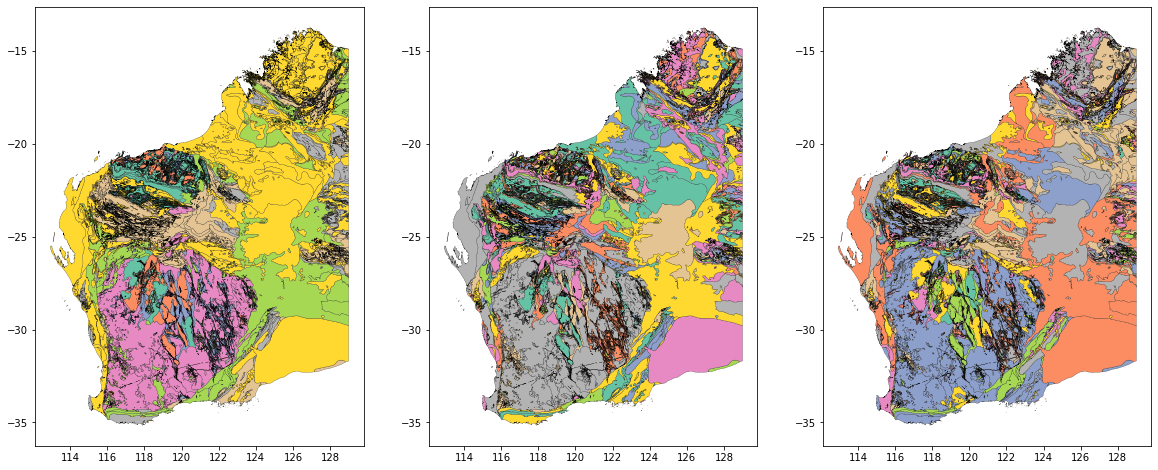

<Figure size 432x288 with 0 Axes>

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1=wa.plot(column='CODE',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax1)
ax2=wa.plot(column='UNITNAME',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax2)
ax3=wa.plot(column='DESCRIPTN',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax3)
plt.figure()

## Quick look into the data

In [46]:
ygsb = gpd.read_file(geology_file)
ygsb

,CODE,UNITNAME,DESCRIPTN,SYMBOL,SORT,LITHSTRTNO,CODE_1,UNITNAME_1,GSWASTATUS,RANK,...,EVENTS,AGEFROM,AGETO,MAX_AGE_MA,MAXUNCERTY,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,geometry
0,A-o-YYO,Youanmi Terrane greenstones,Mafic intrusive rock dominant; metamorphosed,A-o-YYO; Youanmi Terrane greenstones,995,1103,A-o-YYO,Youanmi Terrane greenstones,Informal,Supersuite,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((447823.3466279824 6793304.54047331...
1,A-o-YYO,Youanmi Terrane greenstones,Mafic intrusive rock dominant; metamorphosed,A-o-YYO; Youanmi Terrane greenstones,995,1103,A-o-YYO,Youanmi Terrane greenstones,Informal,Supersuite,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((449979.1330342802 6772687.40709108...
2,A-mu-YYO,Youanmi Terrane greenstones,"Metamorphosed ultramafic rock, undivided; typi...",A-mu-YYO; Youanmi Terrane greenstones,988,1602,A-mu-YYO,Youanmi Terrane greenstones,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((471104.2701248816 6869061.18056475...
3,A-b-YYO,Youanmi Terrane greenstones,Mafic volcanic rock with minor mafic and ultra...,A-b-YYO; Youanmi Terrane greenstones,996,3699,A-b-YYO,Youanmi Terrane greenstones,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((437088.4345811683 6767073.36256263...
4,A-o-YYO,Youanmi Terrane greenstones,Mafic intrusive rock dominant; metamorphosed,A-o-YYO; Youanmi Terrane greenstones,995,1103,A-o-YYO,Youanmi Terrane greenstones,Informal,Supersuite,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((452268.3767408403 6840790.75366134...
5,A-mw-YYO,Youanmi Terrane greenstones,"Metamorphosed mafic igneous rock, undivided",A-mw-YYO; Youanmi Terrane greenstones,980,638,A-mw-YYO,Youanmi Terrane greenstones,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((497867.7445266633 6780004.52379000...
6,A-o-YYO,Youanmi Terrane greenstones,Mafic intrusive rock dominant; metamorphosed,A-o-YYO; Youanmi Terrane greenstones,995,1103,A-o-YYO,Youanmi Terrane greenstones,Informal,Supersuite,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((473768.8987342149 6777233.98899716...
7,A-mn-Y,Yilgarn Craton metamorphic unit,"Gneiss, undivided",A-mn-Y; Yilgarn Craton metamorphic unit,860,3706,A-mn-Y,Yilgarn Craton metamorphic unit,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,2950.0,0.0,2640.0,0.0,Inferred,Inferred,POLYGON Z ((447983.2901012308 6828033.17552592...
8,A-b-YYO,Youanmi Terrane greenstones,Mafic volcanic rock with minor mafic and ultra...,A-b-YYO; Youanmi Terrane greenstones,996,3699,A-b-YYO,Youanmi Terrane greenstones,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((440046.4527644478 6872970.80949425...
9,A-f-YYO,Youanmi Terrane greenstones,Felsic volcanic or volcaniclastic rocks domina...,A-f-YYO; Youanmi Terrane greenstones,994,3692,A-f-YYO,Youanmi Terrane greenstones,Informal,Group,...,Yilgarn Craton granite magmatism (3010 - 2600 ...,Mesoarchean,Neoarchean,3131.0,0.0,2700.0,0.0,Inferred,Inferred,POLYGON Z ((464247.2696140817 6863797.74258372...


<Figure size 432x288 with 0 Axes>

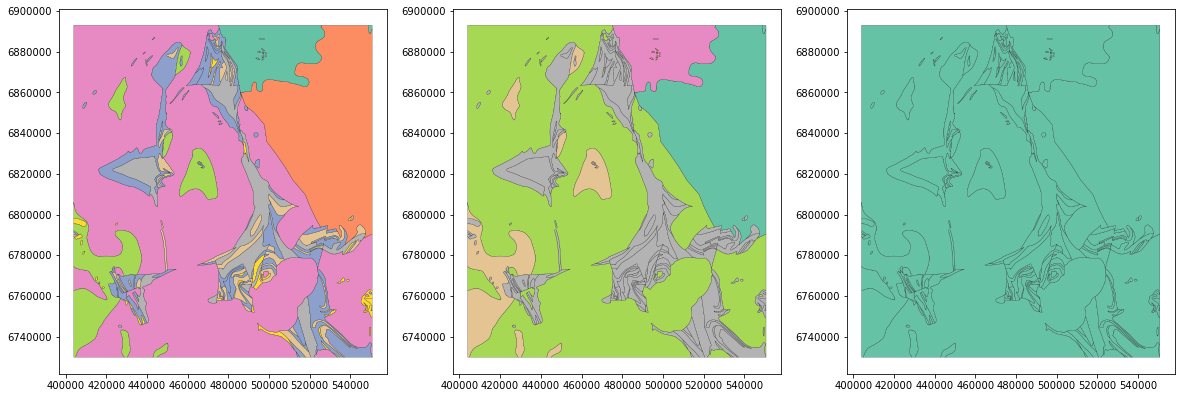

<Figure size 432x288 with 0 Axes>

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1=ygsb.plot(column='CODE',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax1)
ax2=ygsb.plot(column='UNITNAME',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax2)
ax3=ygsb.plot(column='FORMATION',figsize=(7,7), edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax3)
plt.figure()

## Upscale by UNITNAME

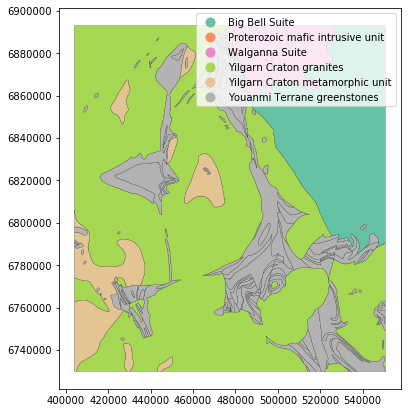

In [48]:
m2l_subsampling.upscale_by (ygsb, 'UNITNAME')

## Vector Aggregation

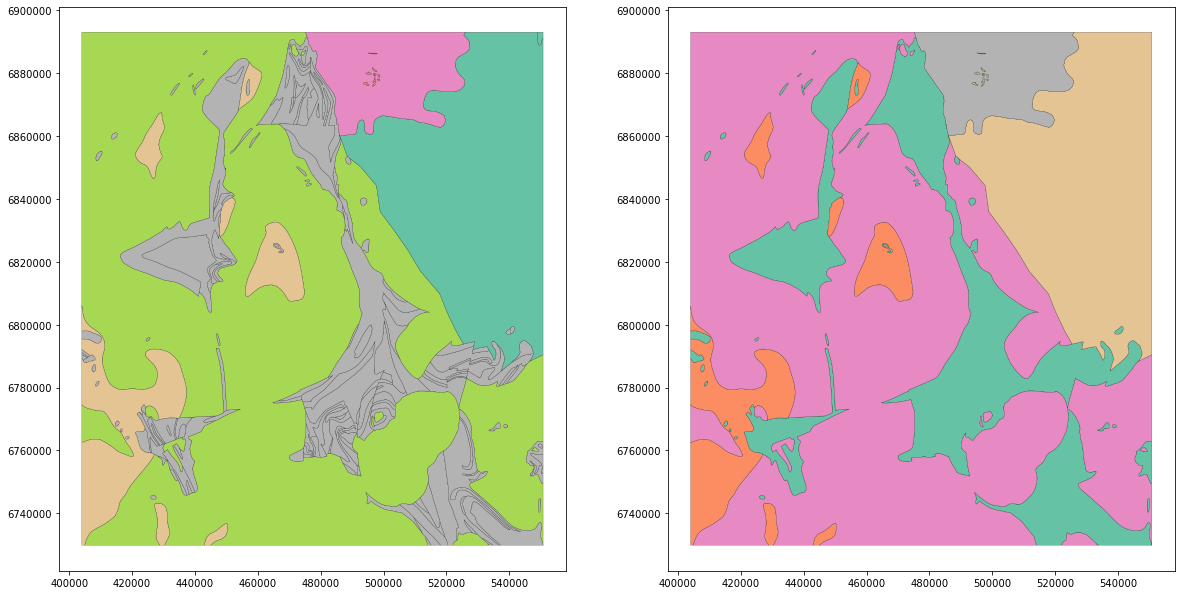

<Figure size 432x288 with 0 Axes>

In [49]:
m2l_subsampling.vector_aggregate (ygsb, 'UNITNAME', 'geometry', aggregate_file)

## Vector Simplification

<Figure size 432x288 with 0 Axes>

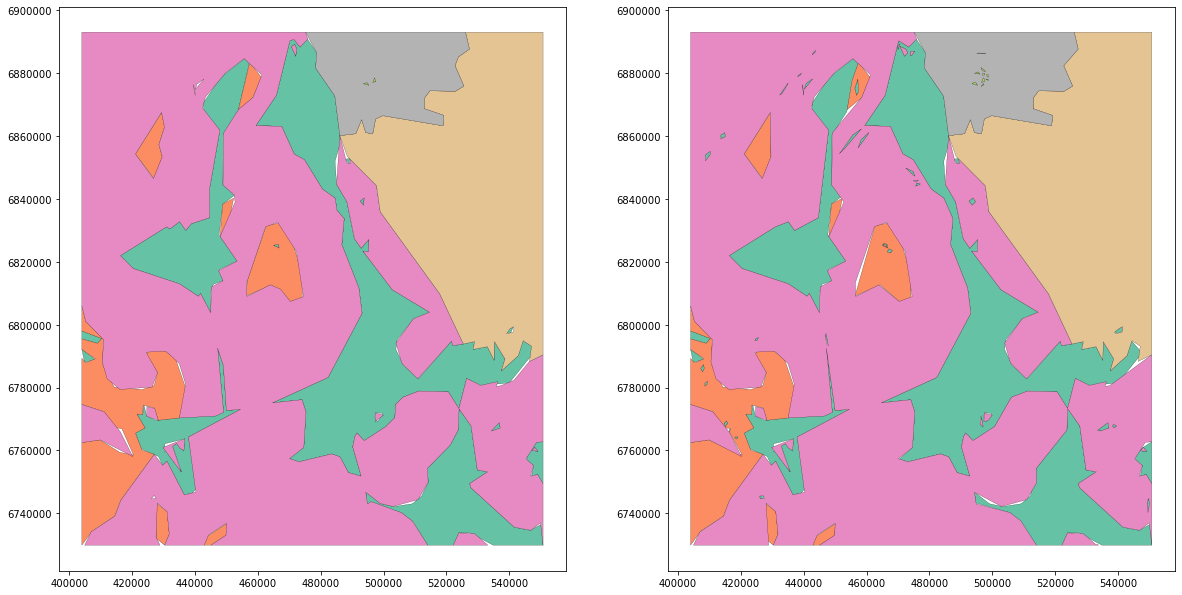

<Figure size 432x288 with 0 Axes>

In [50]:
aggregate = gpd.read_file(aggregate_file)
simplify_false=aggregate.simplify(1000, preserve_topology=False)
simplify_true=aggregate.simplify(1100, preserve_topology=True)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1=simplify_false.plot(edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax1)
ax2=simplify_true.plot(edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax2)
plt.figure()

In [51]:
m2l_subsampling.vector_simplify (aggregate_file, simplified_file, 1100)

In [52]:
a=m2l_subsampling.vector_simplify (aggregate_file, simplified_file_a, 100000)
b=m2l_subsampling.vector_simplify (aggregate_file, simplified_file_b, 1000000)
c=m2l_subsampling.vector_simplify (aggregate_file, simplified_file_c, 2800000)

In [53]:
a=gpd.read_file(simplified_file_a)
b=gpd.read_file(simplified_file_b)
c=gpd.read_file(simplified_file_c)

<Figure size 432x288 with 0 Axes>

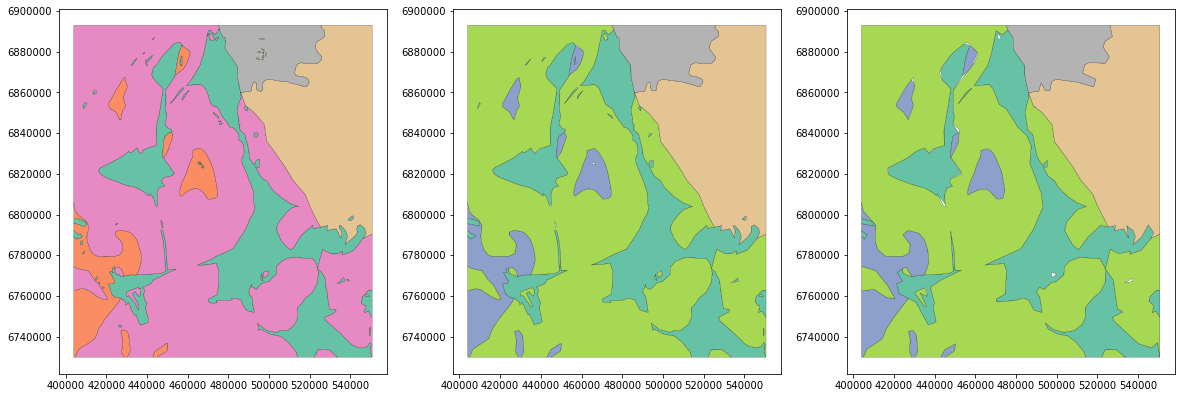

<Figure size 432x288 with 0 Axes>

In [54]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1=a.plot(edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax1)
ax2=b.plot(edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax2)
ax3=c.plot(edgecolor='#000000',linewidth=0.2, cmap='Set2', ax=ax3)
plt.figure()

In [55]:
d=m2l_subsampling.vector_simplify (aggregate_file, simplified_file_d, 2850000)

AttributeError: 'Polygon' object has no attribute 'geoms'